# Ornstein-Uhlenbeck bridges

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt
from tueplots import bundles

plt.rcParams.update(bundles.icml2024())
from flax import nnx

from neuralbridge.sdes.examples import OUSDE, OUBridgeSDE
from neuralbridge.sdes.base import AuxiliarySDE, GuidedBridgeSDE
from neuralbridge.sdes.neural_bridge import NeuralBridge
from neuralbridge.sdes.solver import SDESolver
from neuralbridge.utils.trainer import load

Unconditioned OU process:
$$
\mathrm d X_t = \gamma (\mu - X_t) \mathrm d t + \sigma \mathrm d W_t
$$
Auxiliary process (scaled Brownian motion):
$$
\mathrm d \tilde X_t = \sigma \mathrm d W_t
$$

In [68]:
def construct_neural_bridge(gamma, mu, sigma, x0, vT, T, rngs):
    sde = OUSDE(
        dim=1,
        params={
            "gamma": jnp.array(gamma),
            "mu": jnp.array([mu]),
            "sigma": jnp.array([[sigma]])
        }
    )

    # A standard Brownian motion as the auxiliary SDE
    aux_sde = AuxiliarySDE(
        dim=1,
        coeffs={
            "T": 1.0,
            "beta": lambda t: jnp.array([0.0]),
            "B": lambda t: jnp.array([[0.0]]),
            "a_tilde_0": None,
            "a_tilde_T": jnp.array([[sigma**2]])
        }
    )   

    n_steps = 500
    ts = jnp.linspace(0., 1., n_steps+1)
    epsilon = 1e-5

    guided_sde = GuidedBridgeSDE(
        sde, aux_sde,
        obs_params={
            "vT": vT,
            "LT": jnp.eye(1),   # fully observed
            "SigmaT": epsilon**2 * jnp.eye(1)
        },
        ts=ts,
        eq_type="uLM",          # u, L, M formulation of BIF ODE
    )

    b_fn = guided_sde.b
    sigma_fn = guided_sde.sigma
    G_fn = guided_sde.G

    nn_config = {
        "model_name": "MLPSmall",
        "input_dim": 1,
        "output_dim": 1,
        "hidden_dims": (20, 20, 20),
        "act_type": "lipswish",
        "rngs": rngs
    }
           
    neural_bridge = NeuralBridge(
        b_fn, sigma_fn, G_fn, nn_config
    )
    
    return neural_bridge, guided_sde

The standard OU process holds the transition density:
$$
p_{s,t}(x, y) = \frac{1}{\sqrt{2\pi\Sigma^2_{s,t}}}\exp\left(-\frac{(y - m_{s,t}(x))^2}{2\Sigma^2_{s,t}}\right).
$$
Therefore, without observation noise, the $h(t, x)$ holds the closed-form:
$$
h(t, x) = p_{t, T}(x, v) = \frac{1}{\sqrt{2\pi\Sigma^2_{t,T}}}\exp\left(-\frac{(v - m_{t,T}(x))^2}{2\Sigma^2_{t,T}}\right).
$$
and
$$
\log h(t, x) = -\frac{1}{2}\log(2\pi\Sigma^2_{t, T}) - \frac{(v - m_{t, T}(x))^2}{2\Sigma^2_{t, T}}, \\
\Sigma^2_{t, T} = \frac{\sigma^2}{2\gamma}\left(1 - e^{-2\gamma(T-t)}\right), \\
m_{t, T}(x) = \mu + (x - \mu)e^{-\gamma(T-t)}, \\
\nabla_x\log h(t, x) = \frac{2\gamma e^{-\gamma(T-t)} }{\sigma^2(1-e^{-2\gamma(T-t)})}[(v - \mu) - e^{-\gamma(T-t)}(x - \mu)].
$$
The auxiliary process is a scaled Brownian motion, therefore
$$
\log\tilde h(t, x) = -\frac{1}{2}\log(2\pi\sigma^2(T-t)) - \frac{(v - x)^2}{2\sigma^2(T-t)}, \\
\nabla_x \log \tilde h(t, x) = \frac{v - x}{\sigma^2(T-t)}.
$$
Therefore, the optimal lower bound of $L$ should be:
$$
L(\theta_{\text{opt}}) = \log\tilde h(0, x_0) - \log h(0, x_0) =  -\frac{1}{2}\log(2\pi\sigma^2(T-t)) - \frac{(v - x)^2}{2\sigma^2(T-t)} +\frac{1}{2}\log(2\pi\Sigma^2_{t, T}) + \frac{(v - m_{t, T}(x))^2}{2\Sigma^2_{t, T}}
$$
Similarly, the optimal value of $\vartheta$ can be derived:
$$
\vartheta_{\theta_{\text{opt}}}(t, x) = \sigma^{\top}(\nabla_x\log h(t, x) - \nabla_x\log\tilde h(t, x))
$$ 

In [5]:
def log_tilde_h(t, x, sigma, vT, T):
    return -0.5 * jnp.log(2 * jnp.pi * sigma**2 * (T - t)) - 0.5 * (vT - x)**2 / (sigma**2 * (T - t))

def log_h(t, x, gamma, mu, sigma, vT, T):
    cov = sigma**2 / (2 * gamma) * (1 - jnp.exp(-2 * gamma * (T - t)))
    mean = mu + (x - mu) * jnp.exp(-gamma * (T - t))
    return -0.5 * jnp.log(2 * jnp.pi * cov) - 0.5 * (vT - mean)**2 / cov

def L_opt(gamma, mu, sigma, x0, vT, T):
    return log_tilde_h(0, x0, sigma, vT, T) - log_h(0, x0, gamma, mu, sigma, vT, T)

def nn_opt(gamma, mu, sigma, t, x, vT, T):
    delta = T - t
    exp_delta = jnp.exp(-gamma * delta)
    nabla_log_h = 2 * gamma * exp_delta / (sigma**2 * (1 - exp_delta**2)) * (vT - mu - exp_delta * (x - mu))
    nabla_log_tilde_h = (vT - x) / (sigma**2 * (T - t))
    return sigma * (nabla_log_h - nabla_log_tilde_h)

print(f"Under the setting of gamma={1.7}, mu={1.0}, sigma={0.3}, x0={0.0}, vT={1.0}, T={1.0}, the optimal L is {L_opt(1.7, 1.0, 0.3, 0.0, 1.0, 1.0)}")
print(f"Under the setting of gamma={1.7}, mu={0.0}, sigma={0.3}, x0={0.0}, vT={0.0}, T={1.0}, the optimal L is {L_opt(1.7, 0.0, 0.3, 0.0, 0.0, 1.0)}")
print(f"Under the setting of gamma={0.6}, mu={1.0}, sigma={0.3}, x0={0.0}, vT={1.0}, T={1.0}, the optimal L is {L_opt(0.6, 1.0, 0.3, 0.0, 1.0, 1.0)}")
print(f"Under the setting of gamma={1.7}, mu={1.0}, sigma={1.0}, x0={0.0}, vT={1.0}, T={1.0}, the optimal L is {L_opt(1.7, 1.0, 1.0, 0.0, 1.0, 1.0)}")

Under the setting of theta=1.7, mu=1.0, sigma=0.3, x0=0.0, vT=1.0, T=1.0, the optimal L is -5.532266139984131
Under the setting of theta=1.7, mu=0.0, sigma=0.3, x0=0.0, vT=0.0, T=1.0, the optimal L is -0.6288591623306274
Under the setting of theta=0.6, mu=1.0, sigma=0.3, x0=0.0, vT=1.0, T=1.0, the optimal L is -2.9524893760681152
Under the setting of theta=1.7, mu=1.0, sigma=1.0, x0=0.0, vT=1.0, T=1.0, the optimal L is -1.070165753364563


In [3]:
losses_1 = jnp.load("../assets/ckpts/neural_bridge/ou/theta_0.6_mu_1.0_sigma_0.3/losses.npy")
losses_2 = jnp.load("../assets/ckpts/neural_bridge/ou/theta_1.7_mu_1.0_sigma_0.3/losses.npy")
losses_3 = jnp.load("../assets/ckpts/neural_bridge/ou/theta_1.7_mu_1.0_sigma_1.0/losses.npy")
losses_4 = jnp.load("../assets/ckpts/neural_bridge/ou/theta_1.7_mu_0.0_sigma_0.3/losses.npy")

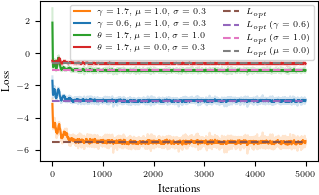

In [6]:
def smooth_losses(losses, window_size=50):
    if window_size >= len(losses):
        return losses
    
    kernel = jnp.ones(window_size) / window_size
    padded_losses = jnp.pad(losses, (window_size//2, window_size//2), mode='edge')
    smoothed = jnp.convolve(padded_losses, kernel, mode='valid')
    
    return smoothed

window_size = 11
smooth_losses_1 = smooth_losses(losses_1, window_size)
smooth_losses_2 = smooth_losses(losses_2, window_size)
smooth_losses_3 = smooth_losses(losses_3, window_size)
smooth_losses_4 = smooth_losses(losses_4, window_size)

fig, ax = plt.subplots()
ax.plot(losses_2, alpha=0.2, color='C1')
ax.plot(smooth_losses_2, label=r'$\gamma = 1.7, \mu = 1.0, \sigma = 0.3$', color='C1')
ax.plot(losses_1, alpha=0.2, color='C0')
ax.plot(smooth_losses_1, label=r'$\gamma = 0.6, \mu = 1.0, \sigma = 0.3$', color='C0')
ax.plot(losses_3, alpha=0.2, color='C2')
ax.plot(smooth_losses_3, label=r'$\theta = 1.7, \mu = 1.0, \sigma = 1.0$', color='C2')
ax.plot(losses_4, alpha=0.2, color='C3')
ax.plot(smooth_losses_4, label=r'$\theta = 1.7, \mu = 0.0, \sigma = 0.3$', color='C3')
ax.hlines(y=L_opt(1.7, 1.0, 0.3, 0.0, 1.0, 1.0), xmin=0, xmax=len(losses_2), linestyle='--', color='C5', label=r'$L_{opt}$')
ax.hlines(y=L_opt(0.6, 1.0, 0.3, 0.0, 1.0, 1.0), xmin=0, xmax=len(losses_1), linestyle='--', color='C4', label=r'$L_{opt}\,(\gamma = 0.6)$')
ax.hlines(y=L_opt(1.7, 1.0, 1.0, 0.0, 1.0, 1.0), xmin=0, xmax=len(losses_3), linestyle='--', color='C6', label=r'$L_{opt}\,(\sigma = 1.0)$')
ax.hlines(y=L_opt(1.7, 0.0, 0.3, 0.0, 0.0, 1.0), xmin=0, xmax=len(losses_4), linestyle='--', color='C7', label=r'$L_{opt}\,(\mu = 0.0)$')

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend(ncol=2)
fig.savefig('../assets/figures/ou/losses.pdf')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Loaded best model from step 1700
Loaded best model from step 1700
Loaded best model from step 1700
Loaded best model from step 4700


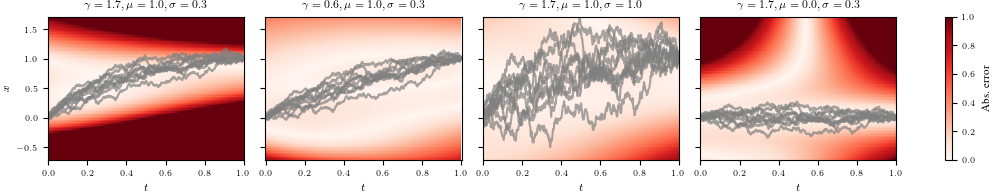

In [75]:
rngs = nnx.Rngs(42)
x0 = jnp.array([0.0])
T = 1.0
n_steps = 500
ts = jnp.linspace(0., 1., n_steps+1)

def vectorized_eval(func, grid_points):
    t_vals = grid_points[:, 0]
    x_vals = grid_points[:, 1].reshape(-1, 1)
    outputs = jax.vmap(lambda t, x: func(t, x))(t_vals, x_vals)
    return outputs.reshape(ts.shape[0], xs.shape[0])

fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharex=True, sharey=True)

norm = plt.Normalize(vmin=0.0, vmax=1.0)

# gamma = 1.7, mu = 1.0, sigma = 0.3
theta = 1.7
mu = 1.0
sigma = 0.3
vT = jnp.array([1.0])
neural_bridge, guided_sde = construct_neural_bridge(theta, mu, sigma, x0, vT, T, rngs)
load(neural_bridge, ckpt_dir="../assets/ckpts/neural_bridge/ou/theta_1.7_mu_1.0_sigma_0.3/")

guide_solve = SDESolver(guided_sde, method='milstein')
guided_traj = guide_solve.batch_solve(jr.PRNGKey(42), x0, ts, 10)

xs = jnp.linspace(-0.7, 1.7, 100)
tt, xx = jnp.meshgrid(ts, xs)
grid_points = jnp.stack([tt.flatten(), xx.flatten()], axis=1) 

true_score = lambda t, x: nn_opt(theta, mu, sigma, t, x, vT, 1.0)

nn_outputs = vectorized_eval(neural_bridge.nn, grid_points)
true_outputs = vectorized_eval(true_score, grid_points)
nn_outputs = nn_outputs.reshape(xs.shape[0], ts.shape[0], 1)
true_outputs = true_outputs.reshape(xs.shape[0], ts.shape[0], 1)
abs_error = jnp.abs(nn_outputs - true_outputs)

im = axes[0].pcolormesh(ts, xs, abs_error[:, :, 0], cmap='Reds', norm=norm)
for i in range(guided_traj.shape[0]):
    axes[0].plot(ts, guided_traj[i], color='grey', alpha=0.7)
axes[0].set_ylabel(r'$x$')
axes[0].set_xlabel(r'$t$')
axes[0].set_title(fr'$\gamma = {theta:.1f}, \mu = {mu:.1f}, \sigma = {sigma:.1f}$')

# gamma = 0.6, mu = 1.0, sigma = 0.3
theta = 0.6
mu = 1.0
sigma = 0.3
vT = jnp.array([1.0])
neural_bridge, guided_sde = construct_neural_bridge(theta, mu, sigma, x0, vT, T, rngs)
load(neural_bridge, ckpt_dir="../assets/ckpts/neural_bridge/ou/theta_0.6_mu_1.0_sigma_0.3/")

guide_solve = SDESolver(guided_sde, method='milstein')
guided_traj = guide_solve.batch_solve(jr.PRNGKey(42), x0, ts, 10)

xs = jnp.linspace(-0.7, 1.7, 100)
tt, xx = jnp.meshgrid(ts, xs)
grid_points = jnp.stack([tt.flatten(), xx.flatten()], axis=1) 

true_score = lambda t, x: nn_opt(theta, mu, sigma, t, x, vT, 1.0)

nn_outputs = vectorized_eval(neural_bridge.nn, grid_points)
true_outputs = vectorized_eval(true_score, grid_points)
nn_outputs = nn_outputs.reshape(xs.shape[0], ts.shape[0], 1)
true_outputs = true_outputs.reshape(xs.shape[0], ts.shape[0], 1)
abs_error = jnp.abs(nn_outputs - true_outputs)

im = axes[1].pcolormesh(ts, xs, abs_error[:, :, 0], cmap='Reds', norm=norm)
for i in range(guided_traj.shape[0]):
    axes[1].plot(ts, guided_traj[i], color='grey', alpha=0.7)
axes[1].set_xlabel(r'$t$')
axes[1].set_title(fr'$\gamma = {theta:.1f}, \mu = {mu:.1f}, \sigma = {sigma:.1f}$')

# gamma = 1.7, mu = 1.0, sigma = 1.0
theta = 1.7
mu = 1.0
sigma = 1.0
vT = jnp.array([1.0])
neural_bridge, guided_sde = construct_neural_bridge(theta, mu, sigma, x0, vT, T, rngs)
load(neural_bridge, ckpt_dir="../assets/ckpts/neural_bridge/ou/theta_1.7_mu_1.0_sigma_1.0/")

guide_solve = SDESolver(guided_sde, method='milstein')
guided_traj = guide_solve.batch_solve(jr.PRNGKey(42), x0, ts, 10)

xs = jnp.linspace(-0.7, 1.7, 100)
tt, xx = jnp.meshgrid(ts, xs)
grid_points = jnp.stack([tt.flatten(), xx.flatten()], axis=1) 

true_score = lambda t, x: nn_opt(theta, mu, sigma, t, x, vT, 1.0)

nn_outputs = vectorized_eval(neural_bridge.nn, grid_points)
true_outputs = vectorized_eval(true_score, grid_points)
nn_outputs = nn_outputs.reshape(xs.shape[0], ts.shape[0], 1)
true_outputs = true_outputs.reshape(xs.shape[0], ts.shape[0], 1)
abs_error = jnp.abs(nn_outputs - true_outputs)  

im = axes[2].pcolormesh(ts, xs, abs_error[:, :, 0], cmap='Reds', norm=norm)
for i in range(guided_traj.shape[0]):
    axes[2].plot(ts, guided_traj[i], color='grey', alpha=0.7)
axes[2].set_xlabel(r'$t$')
axes[2].set_title(fr'$\gamma = {theta:.1f}, \mu = {mu:.1f}, \sigma = {sigma:.1f}$')

# gamma = 1.7, mu = 0.0, sigma = 0.3
theta = 1.7
mu = 0.0
sigma = 0.3
vT = jnp.array([0.0])
neural_bridge, guided_sde = construct_neural_bridge(theta, mu, sigma, x0, vT, T, rngs)
load(neural_bridge, ckpt_dir="../assets/ckpts/neural_bridge/ou/theta_1.7_mu_0.0_sigma_0.3/")

guide_solve = SDESolver(guided_sde, method='milstein')
guided_traj = guide_solve.batch_solve(jr.PRNGKey(42), x0, ts, 10)

xs = jnp.linspace(-0.7, 1.7, 100)
tt, xx = jnp.meshgrid(ts, xs)
grid_points = jnp.stack([tt.flatten(), xx.flatten()], axis=1) 

true_score = lambda t, x: nn_opt(theta, mu, sigma, t, x, vT, 1.0)

nn_outputs = vectorized_eval(neural_bridge.nn, grid_points)
true_outputs = vectorized_eval(true_score, grid_points)
nn_outputs = nn_outputs.reshape(xs.shape[0], ts.shape[0], 1)
true_outputs = true_outputs.reshape(xs.shape[0], ts.shape[0], 1)
abs_error = jnp.abs(nn_outputs - true_outputs)

im = axes[3].pcolormesh(ts, xs, abs_error[:, :, 0], cmap='Reds', norm=norm)
for i in range(guided_traj.shape[0]):
    axes[3].plot(ts, guided_traj[i], color='grey', alpha=0.7)
axes[3].set_xlabel(r'$t$')
axes[3].set_title(fr'$\gamma = {theta:.1f}, \mu = {mu:.1f}, \sigma = {sigma:.1f}$')

cbar = fig.colorbar(im, ax=axes.tolist())
cbar.set_label('Abs. error')

fig.savefig('../assets/figures/ou/errors.pdf')
plt.show()

In [76]:
theta = 1.7
mu = 1.0
sigma = 0.3
x0 = jnp.array([0.0])
vT = jnp.array([1.0])

bridge_sde = OUBridgeSDE(
    dim=1,
    params={
        "theta": jnp.array(theta),
        "mu": jnp.array([mu]),
        "sigma": jnp.array([[sigma]])
    },
    vT=vT,
    T=1.0
)

neural_bridge, _ = construct_neural_bridge(theta, mu, sigma, x0, vT, T, rngs)
load(neural_bridge, ckpt_dir="../assets/ckpts/neural_bridge/ou/theta_1.7_mu_1.0_sigma_0.3/")

nb_solver = SDESolver(neural_bridge, method='milstein')
tb_solver = SDESolver(bridge_sde, method='milstein')

n_samples = 50_000
rng_key = jr.PRNGKey(42)
nb_traj = nb_solver.batch_solve(rng_key, x0, ts, n_samples)
tb_traj = tb_solver.batch_solve(rng_key, x0, ts, n_samples)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Loaded best model from step 1700


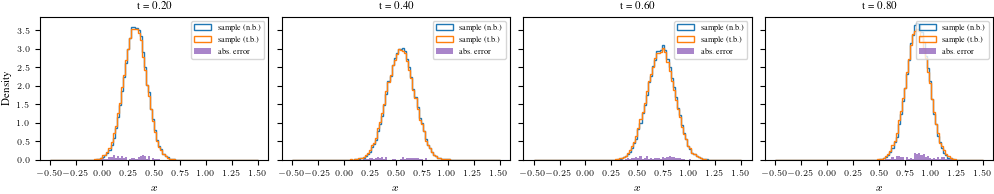

In [78]:
t_slices = [0.2, 0.4, 0.6, 0.8]
x_range = (-0.5, 1.5)

fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=True, sharex=True)

for i, t_slice in enumerate(t_slices):
    t_idx = jnp.where(ts == t_slice)[0][0]
    
    ax = axes[i]
    ax.hist(nb_traj[:, t_idx, 0], bins=100, density=True, range=x_range, label='sample (n.b.)', histtype='step', edgecolor='C0')
    ax.hist(tb_traj[:, t_idx, 0], bins=100, density=True, range=x_range, label='sample (t.b.)', histtype='step', edgecolor='C1')
    
    nb_hist, _       = np.histogram(nb_traj[:, t_idx, 0], bins=100, density=True, range=x_range)
    tb_hist, bin_edges = np.histogram(tb_traj[:, t_idx, 0], bins=100, density=True, range=x_range)
    er_hist = np.abs(nb_hist - tb_hist)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.bar(bin_centers, er_hist, width=np.diff(bin_edges), color='C4', label='abs. error', alpha=0.8, bottom=0.0, fill=True)
    
    ax.set_xlabel(r'$x$')
    ax.set_title(f't = {t_slice:.2f}')
    ax.legend(loc='upper right')

axes[0].set_ylabel('Density')
fig.savefig('../assets/figures/ou/histograms.pdf')
plt.show()